In [12]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 
from collections import defaultdict
from pyecharts import options as opts
from pyecharts.charts import Map
from utils import colors, updated_station_to_city

In [13]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [14]:
data = pd.ExcelFile(r"raw_data.xls")
sheets = data.sheet_names

### 各车次的供给与需求关系示意图

In [18]:
sheet_one = data.parse(sheet_name=sheets[0], index_col="车次")  # parse sheet one
sheet_one = sheet_one[sheet_one.index.notna()].iloc[:-3]  # drop null rows
sheet_one = sheet_one.dropna(axis="columns", how="all")  # drop null columns
first_ten = sheet_one.loc[:, sheet_one.columns[sheet_one.columns.get_loc("上旬"):]].dropna()
first_ten.columns = ["定员", "无座", "合计", "发送", "上座率"]
first_ten["日均定员"], first_ten["日均发送"] = first_ten["定员"] / 10, first_ten["发送"] / 10
first_ten = first_ten.apply(pd.to_numeric, errors='coerce')
first_ten.head(3)

,定员,无座,合计,发送,上座率,日均定员,日均发送
车次,,,,,,,
G6202,5360,700,6060,4925,0.918843,536.0,492.5
G6204,2680,350,3030,1692,0.631343,268.0,169.2
G6206,5360,700,6060,4351,0.811754,536.0,435.1


In [19]:
sheet_two = data.parse(sheet_name=sheets[1], index_col="车次")  # parse sheet one
sheet_two = sheet_two[sheet_two.index.notna()].iloc[:-3]  # drop null rows
sheet_two = sheet_two.dropna(axis="columns", how="all")  # drop null columns
sec_ten = sheet_two.loc[:, sheet_two.columns[sheet_two.columns.get_loc("中旬"):]].dropna()
sec_ten.columns = ["定员", "无座", "合计", "发送", "上座率"]
sec_ten["日均定员"], sec_ten["日均发送"] = sec_ten["定员"] / 10, sec_ten["发送"] / 10
sec_ten = sec_ten.apply(pd.to_numeric, errors='coerce')
sec_ten.head(3)

,定员,无座,合计,发送,上座率,日均定员,日均发送
车次,,,,,,,
G6202,5360,700,6060,4873,0.909142,536.0,487.3
G6204,3216,420,3636,2098,0.652363,321.6,209.8
G6206,5360,700,6060,4196,0.782836,536.0,419.6


In [20]:
sheet_thr = data.parse(sheet_name=sheets[2], index_col="车次")  # parse sheet one
sheet_thr = sheet_thr[sheet_thr.index.notna()].iloc[:-3]  # drop null rows
sheet_thr = sheet_thr.dropna(axis="columns", how="all")  # drop null columns
thr_ten = sheet_thr.loc[:, sheet_thr.columns[sheet_thr.columns.get_loc("下旬"):]].dropna()
thr_ten.columns = ["定员", "无座", "合计", "发送", "上座率"]
thr_ten["日均定员"], thr_ten["日均发送"] = thr_ten["定员"] / 10, thr_ten["发送"] / 10
thr_ten = thr_ten.apply(pd.to_numeric, errors='coerce')
thr_ten.head(3)

,定员,无座,合计,发送,上座率,日均定员,日均发送
车次,,,,,,,
G6202,5360,700,6060,5216,0.973134,536.0,521.6
G6204,3216,420,3636,2890,0.898632,321.6,289.0
G6206,5360,700,6060,5060,0.944030,536.0,506.0


In [21]:
sheet_four = data.parse(sheet_name=sheets[3], index_col="车次")  # parse sheet one
sheet_four = sheet_four[sheet_four.index.notna()].iloc[:-4]
common_index = first_ten.index.intersection(sec_ten.index).intersection(thr_ten.index)  # some trains only run for 10 or 20 days
all_month = sheet_four.loc[:, sheet_four.columns[sheet_four.columns.get_loc("月计"):]].dropna()
all_month.columns = ["定员", "无座", "合计", "发送", "上座率"]
all_month["日均定员"], all_month["日均发送"] = all_month["定员"] / 30, all_month["发送"] / 30
all_month = all_month.apply(pd.to_numeric, errors='coerce')
all_month = all_month[all_month.index.isin(common_index)] 
all_month.head(3)

,定员,无座,合计,发送,上座率,日均定员,日均发送
车次,,,,,,,
G6202,16080,2100,18180,15014,0.933706,536.000000,500.466667
G6204,9112,1190,10302,6680,0.733099,303.733333,222.666667
G6206,16080,2100,18180,13607,0.846206,536.000000,453.566667


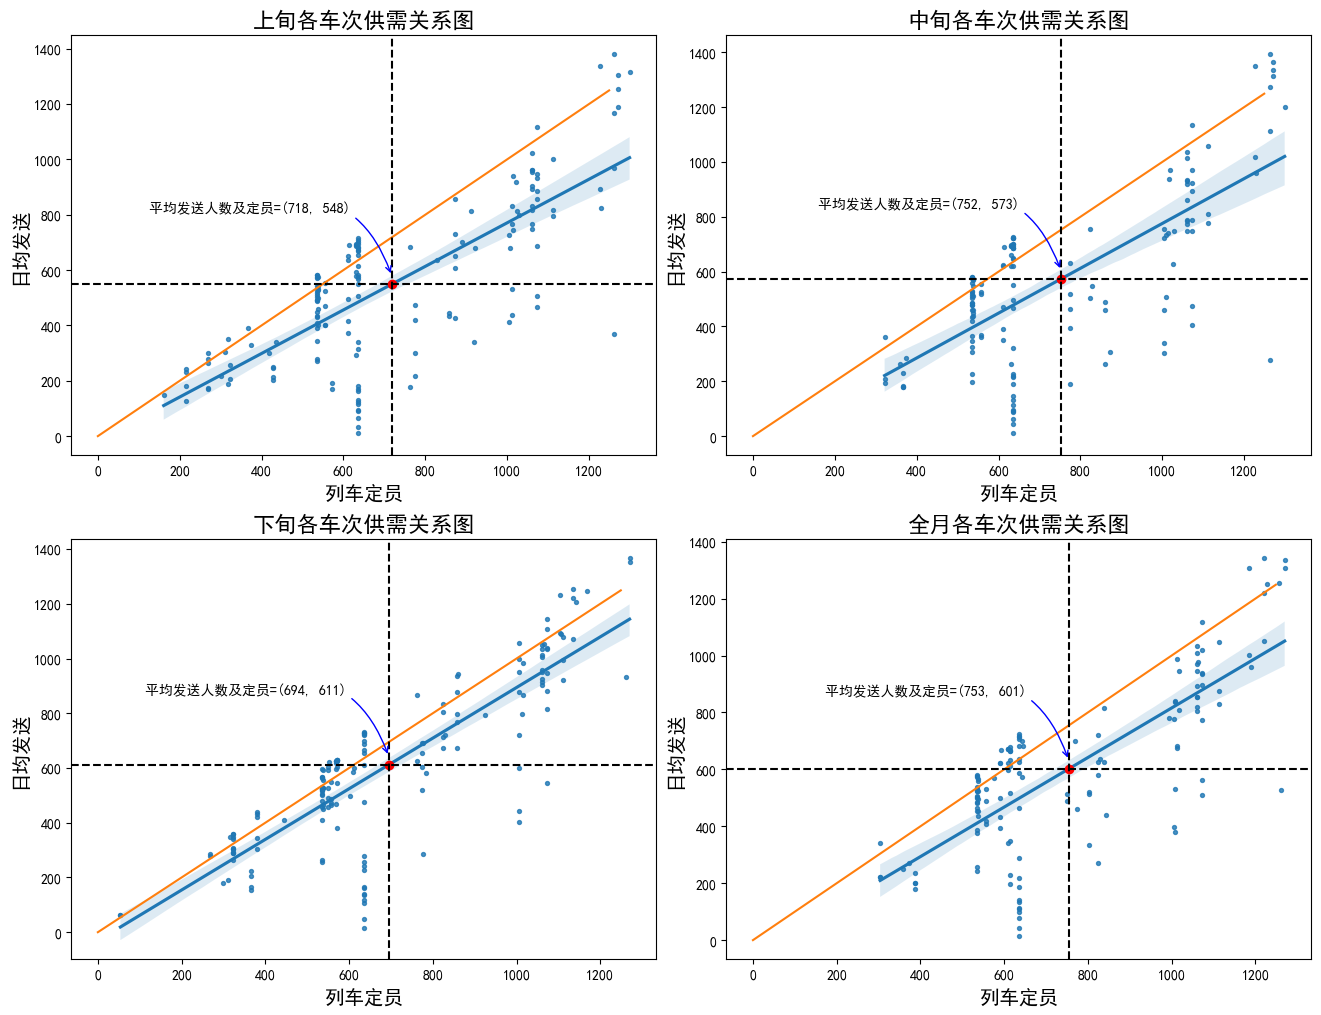

In [22]:
con_data = [[first_ten, sec_ten], [thr_ten, all_month]]
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
titles = ["上旬各车次供需关系图", "中旬各车次供需关系图", "下旬各车次供需关系图", "全月各车次供需关系图"]
for i in range(2):
    for j in range(2):
        mean_capacity = con_data[i][j]['日均定员'].mean()  
        mean_passenger = con_data[i][j]['日均发送'].mean()
        sns.regplot(x="日均定员", y="日均发送", data=con_data[i][j], ax=axes[i][j], scatter_kws={'s': 8})
        # 绘制平均值点  
        axes[i][j].plot(mean_capacity, mean_passenger, 'ro')
        axes[i][j].set_xlabel('列车定员', fontsize=14) 
        axes[i][j].set_ylabel('日均发送', fontsize=14)
        axes[i][j].set_title(titles[2*i+j], fontsize=16)
        axes[i][j].plot(np.arange(1250))
        axes[i][j].annotate(f"平均发送人数及定员={int(mean_capacity), int(mean_passenger)}", xy=(mean_capacity, mean_passenger+30),
                            xytext=(mean_capacity-100, mean_passenger+300),
                                    arrowprops=dict(arrowstyle='->',
                                    color='blue',
                                    lw=1,
                                    connectionstyle='arc3,rad=-0.5'),
                            horizontalalignment="right", verticalalignment="top")
        axes[i][j].axhline(y=mean_passenger, color='black', linestyle='--')  
        axes[i][j].axvline(x=mean_capacity, color='black', linestyle='--')  
fig.subplots_adjust(wspace=0.12)

### 列车开点与上座率的关系示意图

In [23]:
data_one = data.parse(sheet_name=sheets[0], index_col="车次")
data_one = data_one[data_one.index.notna()].iloc[:-3].dropna(axis="columns", how="all")
data_one = pd.merge(data_one["开点"], data_one.iloc[:, 1::5], left_index=True, right_index=True)
data_one = data_one.dropna()
cols = ["开点", "到站"]
for i in range(1, 11):
    cols.append(str(i))
cols.append("上旬平均")
data_one.columns = cols
data_one['开点'] = pd.to_datetime(data_one['开点'], format='%H:%M:%S').dt.strftime('%H')
for col in data_one.columns[2:]:
    data_one[col] = data_one[col].astype(float) 
data_one.set_index("开点", inplace=True)
data_one = data_one.iloc[:, 1:]
data_one = data_one.groupby('开点').mean()
data_one.head(3)

,1,2,3,4,5,6,7,8,9,10,上旬平均
开点,,,,,,,,,,,
06,0.056693,0.006299,0.015748,0.015748,0.004724,0.026772,0.012598,0.020472,0.017323,0.023622,0.020000
07,0.526569,0.553357,0.950035,0.587557,0.480996,0.550928,0.524911,0.450547,0.477235,0.523388,0.563597
08,0.620333,0.686066,0.952156,0.710679,0.589541,0.657032,0.611640,0.578441,0.581839,0.621767,0.659949


In [24]:
data_two = data.parse(sheet_name=sheets[1], index_col="车次")
data_two = data_two[data_two.index.notna()].iloc[:-3].dropna(axis="columns", how="all")
data_two = pd.merge(data_two["开点"], data_two.iloc[:, 1::5], left_index=True, right_index=True)
data_two = data_two.dropna()
cols = ["开点", "到站"]
for i in range(11, 21):
    cols.append(str(i))
cols.append("中旬平均")
data_two.columns = cols
data_two['开点'] = pd.to_datetime(data_two['开点'], format='%H:%M:%S').dt.strftime('%H')
for col in data_two.columns[2:]:
    data_two[col] = data_two[col].astype(float) 
data_two.set_index("开点", inplace=True)
data_two = data_two.iloc[:, 1:]
data_two = data_two.groupby('开点').mean()
data_two.head(3)

,11,12,13,14,15,16,17,18,19,20,中旬平均
开点,,,,,,,,,,,
06,0.007874,0.009449,0.025197,0.042520,0.015748,0.011024,0.012598,0.020472,0.018898,0.012598,0.017638
07,0.499225,0.683368,0.482676,0.587879,0.466840,0.459647,0.447372,0.485685,0.689292,0.470528,0.527300
08,0.622783,0.786398,0.625385,0.684485,0.642408,0.610896,0.602046,0.654786,0.793292,0.616631,0.663911


In [25]:
data_three = data.parse(sheet_name=sheets[2], index_col="车次")
data_three = data_three[data_three.index.notna()].iloc[:-3].dropna(axis="columns", how="all")
data_three = pd.merge(data_three["开点"], data_three.iloc[:, 1::5], left_index=True, right_index=True)
data_three = data_three.dropna()
cols = ["开点", "到站"]
for i in range(21, 31):
    cols.append(str(i))
cols.append("下旬平均")
data_three.columns = cols
data_three['开点'] = pd.to_datetime(data_three['开点'], format='%H:%M:%S').dt.strftime('%H')
for col in data_three.columns[2:]:
    data_three[col] = data_three[col].astype(float) 
data_three.set_index("开点", inplace=True)
data_three = data_three.iloc[:, 1:]
data_three = data_three.groupby('开点').mean()
data_three.head(3)

,21,22,23,24,25,26,27,28,29,30,下旬平均
开点,,,,,,,,,,,
06,0.028346,0.015748,0.020472,0.011024,0.023622,0.014173,0.009449,0.067717,0.015748,0.023622,0.022992
07,0.578707,0.502267,0.664624,0.825766,0.776809,0.865858,0.893643,0.867218,0.885938,0.848996,0.775521
08,0.756358,0.649070,0.730001,0.807423,0.797640,0.935217,0.909339,0.837009,0.860766,0.870744,0.817818


In [26]:
data_all = data.parse(sheet_name=sheets[3], index_col="车次")
data_all = data_all[data_all.index.notna()].iloc[:-4].dropna(axis="columns", how="all")
data_all = pd.merge(data_all["开点"], data_all.iloc[:, -1], left_index=True, right_index=True)
data_all = data_all.dropna()
data_all.columns = ["开点", "月总"]
data_all['开点'] = pd.to_datetime(data_all['开点'], format='%H:%M:%S').dt.strftime('%H')
data_all["月总"] = data_all["月总"].astype(float)
data_all.set_index("开点", inplace=True)
data_all = data_all.groupby('开点')['月总'].mean()
data_all.head()

开点
06    0.526899
07    0.628417
08    0.716090
09    0.801082
10    0.912757
Name: 月总, dtype: float64

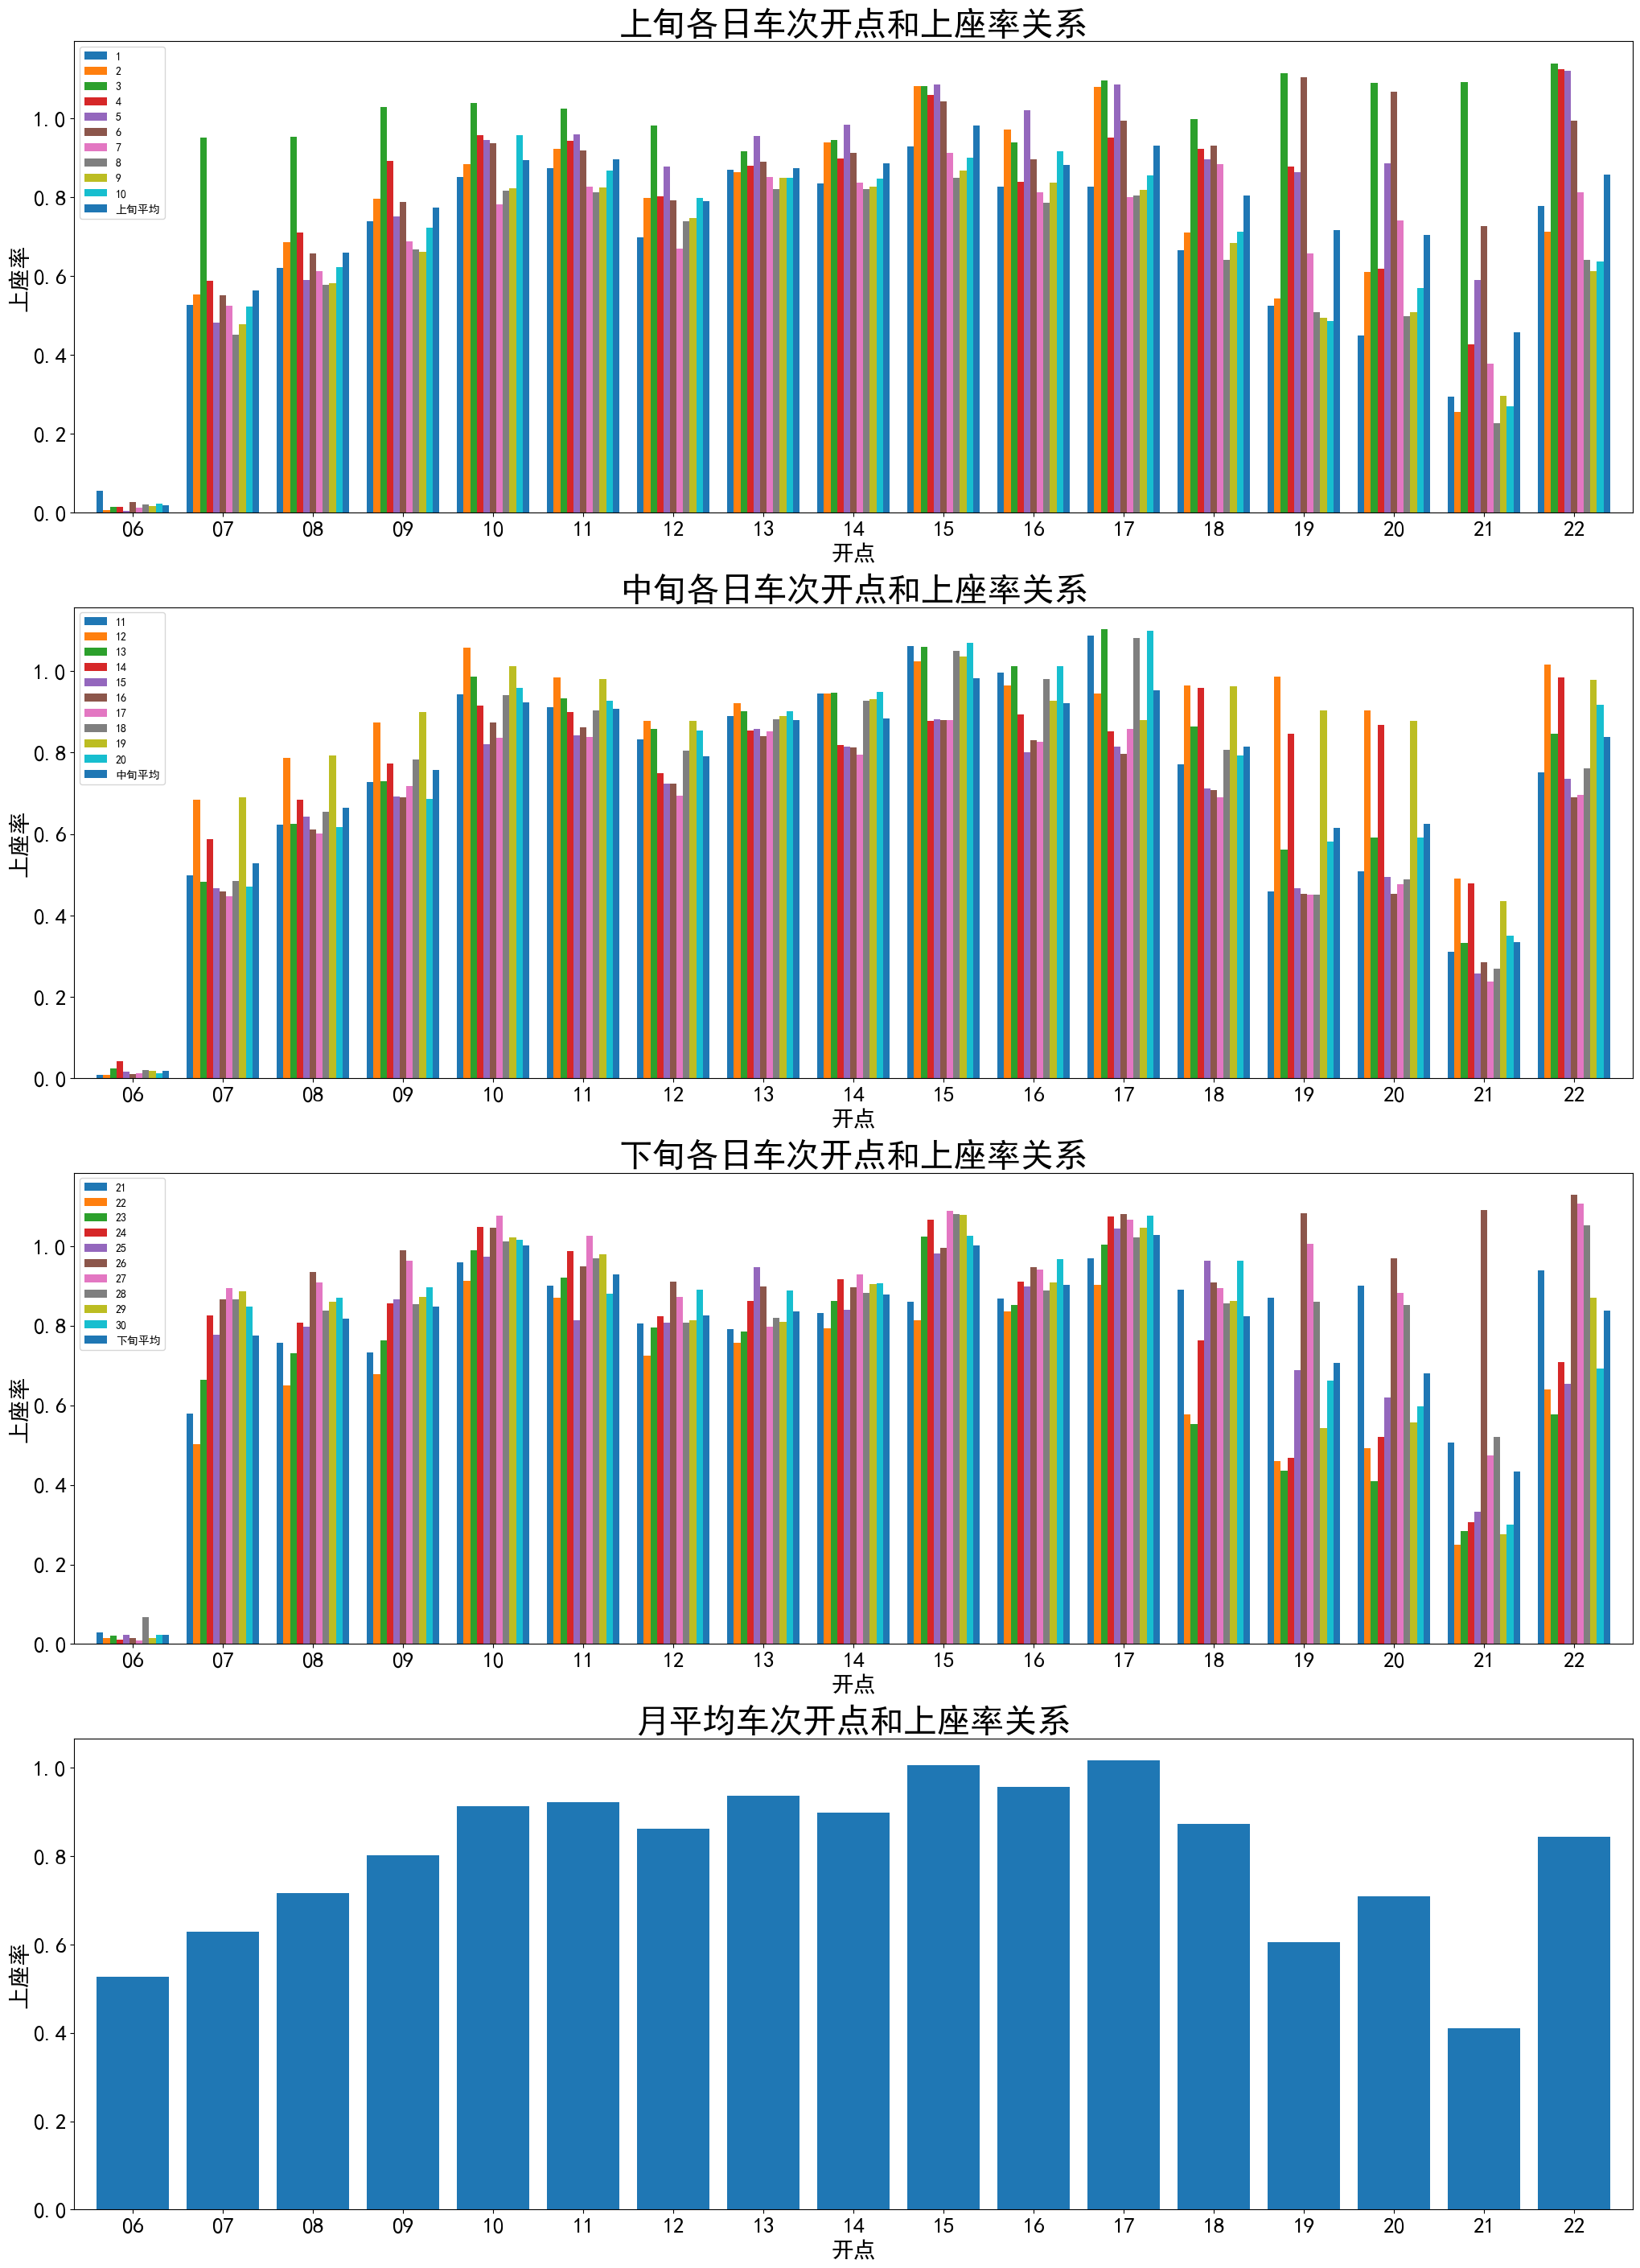

In [27]:
fig, axes = plt.subplots(4, 1, figsize=(25, 35))
data_list = [[data_one, data_two], [data_three, data_all]]
title_list = [["上旬各日", "中旬各日"], ["下旬各日", "月平均"]]
for i in range(2):
    for j in range(2):
        data_list[i][j].plot.bar(ax=axes[i*2+j], rot=0, width=0.8)
        axes[i*2+j].set_xlabel('开点', fontsize=20)
        axes[i*2+j].set_ylabel('上座率', fontsize=20)
        axes[i*2+j].tick_params(axis='both', which='major', labelsize=20)
        axes[i*2+j].set_title(f"{title_list[i][j]}车次开点和上座率关系", fontsize=30)